# Group Assignment II: Advanced Econometrics

Authors: 
Rick Geling, 2804908 \
Perry Boer, 2665575 \
Archit Murkunde, 2845576 \
Michiel van der Groen, 2820428

## Libraries & Data Prepping

### Libraries

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
import numdifftools as nd
import warnings
from scipy import stats
from functools import partial
from scipy.stats import chi2, norm
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=FutureWarning)

### Preparing data for analysis

In [6]:
ab_data = pd.read_csv('Solara_AB_data.csv')
ab_data.head()

,dates,s,g,y
0,01-01-2024,4260.478186,220.873050,217.988012
1,02-01-2024,4392.088417,210.723291,188.028484
2,03-01-2024,3573.676586,151.117026,249.976529
3,04-01-2024,3245.750115,188.584675,289.264673
4,05-01-2024,3173.069842,201.874913,212.419362


In [7]:
ab_data.describe()

,s,g,y
count,182.000000,182.000000,182.000000
mean,3492.357893,236.594453,247.772498
std,765.051043,86.679582,75.792096
min,1551.481328,40.260145,30.159426
25%,3005.048988,179.391558,202.159364
50%,3489.379356,236.195809,251.530881
75%,3940.242695,285.419673,294.942235
max,5721.467267,496.407093,499.461742


## 1.1 Marketing campaign effectiveness

## Question II: Filtered google and youtube adstocks

In [10]:
def google_adstock(g_t, alpha_g, beta_g, delta_g, gadst1):
    """
    Google adstock model
    """
    gadst = [gadst1]
    for t in range(1, len(g_t)):
        gadst_t = (alpha_g * g_t[t]) / (1 + delta_g * gadst[t-1]) + beta_g * gadst[t-1]
        gadst.append(gadst_t)
    return np.array(gadst)

def youtube_adstock(y_t, alpha_y, beta_y, delta_y, yadst1):
    """
    Youtube adstock model
    """
    yadst = [yadst1]
    for t in range(1, len(y_t)):
        yadst_t = (alpha_y * y_t[t]) / (1 + delta_y * yadst[t-1]) + beta_y * yadst[t-1]
        yadst.append(yadst_t)
    return np.array(yadst)

def plot_adstock(gadst, yadst):
    """
    Plot filtered adstock values and distributions
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Filtered google adstock
    axes[0, 0].plot(gadst, label='Google Adstock', color='blue')
    axes[0, 0].set_title('Filtered Google Adstock')
    axes[0, 0].set_xlabel('Time (days)')
    axes[0, 0].set_ylabel('Adstock Value')
    axes[0, 0].legend()

    # Filtered youTube adstock
    axes[1, 0].plot(yadst, label='YouTube Adstock', color='black')
    axes[1, 0].set_title('Fitlered YouTube Adstock')
    axes[1, 0].set_xlabel('Time (days)')
    axes[1, 0].set_ylabel('Adstock Value')
    axes[1, 0].legend()

    # Histogram google
    axes[0, 1].hist(gadst, bins=50, color='blue', alpha=1)
    axes[0, 1].set_title('Google Adstock Distribution')
    axes[0, 1].set_xlabel('Adstock Value')
    axes[0, 1].set_ylabel('Frequency')

    # Histogram youtube
    axes[1, 1].hist(yadst, bins=50, color='black', alpha=1)
    axes[1, 1].set_title('YouTube Adstock Distribution')
    axes[1, 1].set_xlabel('Adstock Value')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

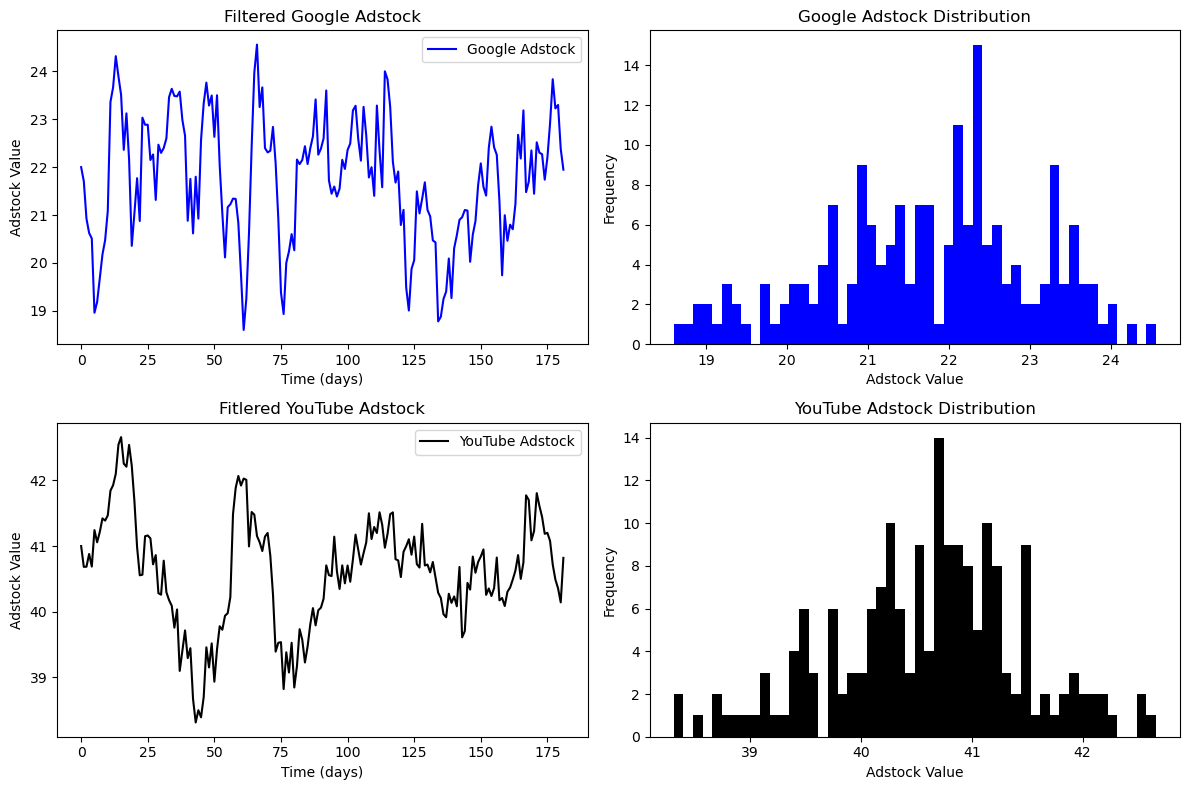

Google Adstock Skewness: -0.30467433460311527
YouTube Adstock Skewness: -0.23822970499550392


In [11]:
gt = ab_data['g'].values
yt = ab_data['y'].values

# Parameter estimates and initial values
alpha_g, beta_g, delta_g = 2, 0.9, 10
alpha_y, beta_y, delta_y = 1, 0.97, 5
gadst1, yadst1 = 22, 41

# filter data and plot
gadst = google_adstock(gt, alpha_g, beta_g, delta_g, gadst1)
yadst = youtube_adstock(yt, alpha_y, beta_y, delta_y, yadst1)
plot_adstock(gadst, yadst)

# check skewness
print('Google Adstock Skewness:', pd.Series(gadst).skew())
print('YouTube Adstock Skewness:', pd.Series(yadst).skew())

## Question III estimate parameters of the linear model

In [13]:
def linear_model_loss(params, gadst, yadst, st):
    """
    linear model loss function using least squares.
    """
    mu, phi_g, phi_y = params
    predicted = mu + phi_g * gadst + phi_y * yadst
    loss = np.sum((st - predicted) ** 2)
    
    return loss

def estimate_linear_model(params_init, gadst, yadst, st):
    """
    linear model estimation 
    """
    result = minimize(linear_model_loss, params_init, args=(gadst, yadst, st), method='BFGS')
    
    mu_hat, phi_g_hat, phi_y_hat = result.x
    
    return mu_hat, phi_g_hat, phi_y_hat


In [14]:
# Initial values
st = ab_data['s'].values
mu_0 = np.mean(st)
phi_g_0 = 0.4
phi_y_0 = 0.5
params_init = [mu_0, phi_g_0, phi_y_0]

# Estimate 
mu_hat, phi_g_hat, phi_y_hat = estimate_linear_model(params_init, gadst, yadst, st)

# results
mu_hat, phi_g_hat, phi_y_hat

(-27071.198820411588, 420.3021788300962, 527.6773961147982)

### Check if results are the same? using statsmodels

In [16]:
X = np.column_stack((gadst, yadst))
X = sm.add_constant(X) 

model = sm.OLS(st, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     911.4
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           1.43e-94
Time:                        19:13:45   Log-Likelihood:                -1246.5
No. Observations:                 182   AIC:                             2499.
Df Residuals:                     179   BIC:                             2509.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.707e+04    844.719    -32.048      0.0

### Question IV: long-run adstock convergence 

In [18]:
def limit_adstock(alpha, beta, delta, daily_adstock):
    """
    Limit adsotck solver using quadratic formula
    """
    # solve using quadratic formula
    a = (1 - beta) * delta
    b = (1 - beta)
    c = -alpha * daily_adstock

    # calculate the discriminant
    discriminant = b**2 - 4*a*c

    limit_gads = (-b + np.sqrt(discriminant)) / (2 * a)

    return limit_gads

In [19]:
daily_adstock_g = daily_adstock_y = 250 

gads_limit = limit_adstock(alpha_g, beta_g, delta_g, daily_adstock_g)
yads_limit = limit_adstock(alpha_y, beta_y, delta_y, daily_adstock_y)

gads_limit, yads_limit

(22.31073567662746, 40.724951520689714)

### Question V: compute IRFs

In [21]:
def compute_sales(mu, phi_alpha, phi_beta, alpha_adstocks, beta_adstocks):
    """
    Compute sales using linear model
    """
    return mu + phi_alpha * np.array(alpha_adstocks) + phi_beta * np.array(beta_adstocks)

def compute_irf(alpha, beta, delta, phi_alpha, phi_beta, mu, alpha_limit, beta_limit, impulse, n_periods=60, pre_impulse_periods=5):
    """
    Compute impulse response function,
    alpha and beta are the adstock parameters, alpha has an extra impulse, where beta is constant
    """
    # add t-5 values to alpha and beta
    alpha_adstocks = [alpha_limit] * pre_impulse_periods  
    beta_adstocks = [beta_limit] * pre_impulse_periods    

    # impulse
    for t in range(n_periods):
        if t == 0:  # impulse at t=0
            current_investment = 250 + impulse
        else:
            current_investment = 250
        
        # Update alpha adstock
        new_alpha_stock = (alpha * current_investment) / (1 + delta * alpha_adstocks[-1]) + beta * alpha_adstocks[-1]
        alpha_adstocks.append(new_alpha_stock)
        beta_adstocks.append(beta_limit) 

    # compute sales 
    sales = compute_sales(mu, phi_alpha, phi_beta, alpha_adstocks, beta_adstocks)
    
    return np.array(sales), np.array(alpha_adstocks)

def plot_irf(sales_google, sales_youtube):
    """
    Plot IRF and cumulative sales response
    """
    # Compute cumulative sales response
    cumulative_sales_google = np.cumsum(sales_google - sales_google[0])
    cumulative_sales_youtube = np.cumsum(sales_youtube - sales_youtube[0])
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot daily response for Google Ads impulse
    axes[0, 0].plot(sales_google, label="Sales (Google)", color='blue')
    axes[0, 0].set_title('Sales (Google Ads Impulse)')
    axes[0, 0].set_xlabel('Time (days)')
    axes[0, 0].set_ylabel('Sales')
    axes[0, 0].legend(loc = 'upper right')

    # Plot cumulative response for Google Ads impulse
    axes[0, 1].plot(cumulative_sales_google, label="Cumulative Response (Google)", color='blue')
    axes[0, 1].set_title('Cumulative Sales Response (Google Ads Impulse)')
    axes[0, 1].set_xlabel('Time (days)')
    axes[0, 1].set_ylabel('Cumulative Change in Sales')
    axes[0, 1].legend(loc = 'lower right')

    # Plot daily response for YouTube Ads impulse
    axes[1, 0].plot(sales_youtube, label="Sales (YouTube)", color='black')
    axes[1, 0].set_title('Sales (YouTube Ads Impulse)')
    axes[1, 0].set_xlabel('Time (days)')
    axes[1, 0].set_ylabel('Sales')
    axes[1, 0].legend(loc = 'upper right')

    # Plot cumulative response for YouTube Ads impulse
    axes[1, 1].plot(cumulative_sales_youtube, label="Cumulative Response (YouTube)", color='black')
    axes[1, 1].set_title('Cumulative Sales Response (YouTube Ads Impulse)')
    axes[1, 1].set_xlabel('Time (days)')
    axes[1, 1].set_ylabel('Cumulative Change in Sales')
    axes[1, 1].legend(loc = 'lower right')

    plt.tight_layout()
    plt.show()

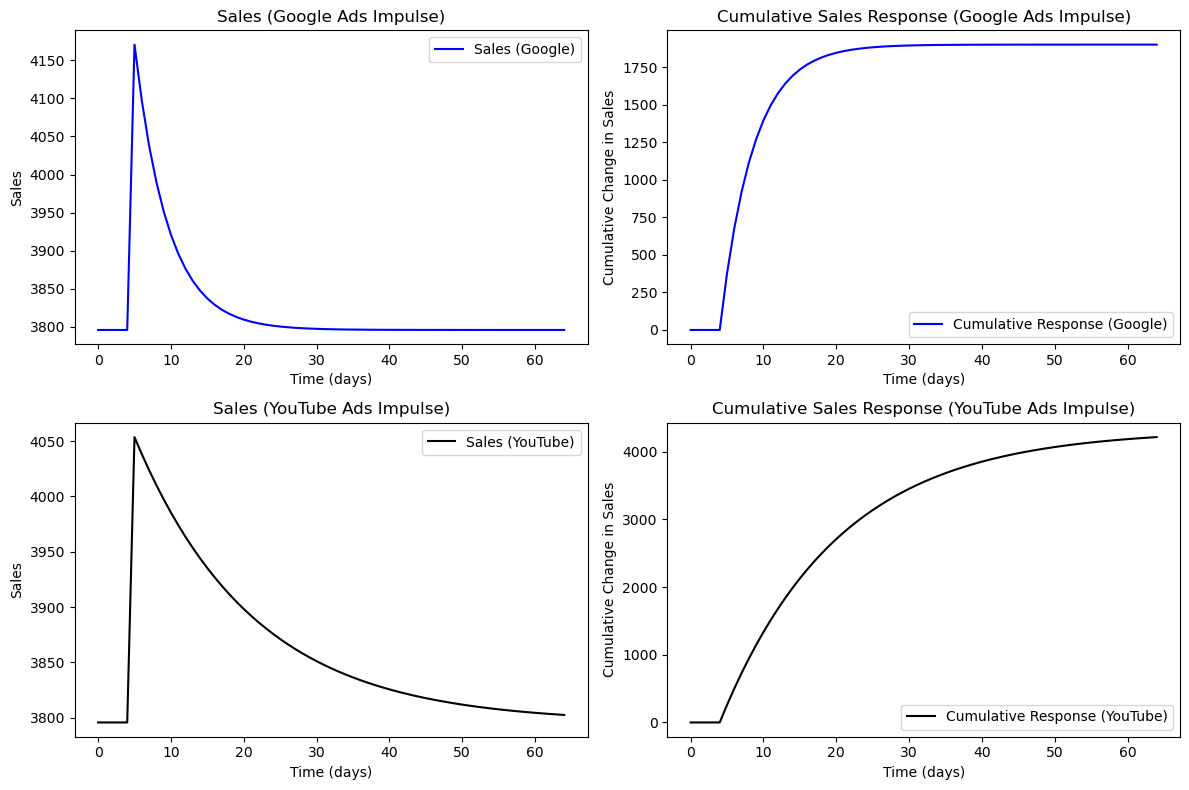

In [22]:
impulse = 100  # Impulse 

# Google, youtube IRF
sales_google, _ = compute_irf(alpha_g, beta_g, delta_g, phi_g_hat, phi_y_hat, mu_hat, gads_limit, yads_limit, impulse)
sales_youtube, _ = compute_irf(alpha_y, beta_y, delta_y, phi_y_hat, phi_g_hat, mu_hat, yads_limit, gads_limit, impulse)

# Plot IRFs
plot_irf(sales_google, sales_youtube)

## 1.2 Dynamic pricing 

### preparing data for analysis

In [25]:
pricing_data = pd.read_csv('Solara_pricing_data.csv')
pricing_data.head()

,dates,s,p,c,m
0,01/01/2005,500.000000,50.000000,20.021805,33.200625
1,08/01/2005,449.303860,55.882011,18.674723,32.712796
2,15/01/2005,564.330379,48.051099,17.063911,32.103796
3,22/01/2005,493.957460,49.484867,16.296832,29.963024
4,29/01/2005,541.364038,42.867625,17.041808,33.215894


In [26]:
pricing_data.describe()

,s,p,c,m
count,1018.000000,1018.000000,1018.000000,1018.000000
mean,501.231388,50.293477,20.245129,30.225551
std,51.805050,4.975342,3.936634,6.690768
min,319.983781,35.816681,6.928023,4.044274
25%,467.040744,46.686790,18.273961,25.686819
50%,500.932404,50.379808,20.733797,30.678694
75%,535.570757,53.511117,22.732560,35.290920
max,673.374259,66.575604,30.107543,48.686392


### Question VII: plot given data 

In [28]:
def plot_solara_pricing_data(data):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Sales (s)
    ax[0, 0].plot(data['dates'], data['s'], color='blue', label='Sales')
    ax[0, 0].set_ylabel('Sales (weekly)')
    ax[0, 0].set_title('Sales over Time')
    ax[0, 0].legend()
    ax[1, 1].set_xlabel('Time')

    # Prices (P)
    ax[0, 1].plot(data['dates'], data['p'], color='green', label='Prices')
    ax[0, 1].set_ylabel('Prices (weekly)')
    ax[0, 1].set_title('Prices over Time')
    ax[0, 1].legend()
    ax[1, 1].set_xlabel('Time')

    # Acquisition Costs (c)
    ax[1, 0].plot(data['dates'], data['c'], color='red', label='Acquisition Costs')
    ax[1, 0].set_ylabel('Acquisition Costs (weekly)')
    ax[1, 0].set_title('Acquisition Costs over Time')
    ax[1, 0].legend()
    ax[1, 1].set_xlabel('Time')

    # Marketing Expenditures (m)
    ax[1, 1].plot(data['dates'], data['m'], color='purple', label='Marketing Expenditures')
    ax[1, 1].set_ylabel('Marketing Expenditures (weekly)')
    ax[1, 1].set_title('Marketing Expenditures over Time')
    ax[1, 1].legend()
    ax[1, 1].set_xlabel('Time')

    for a in ax.flatten():
        a.set_xlabel('Time')
        a.xaxis.set_major_locator(mdates.YearLocator())
        a.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        a.set_xlim([pd.to_datetime('2006-01-01'), data['dates'].max()])
        plt.setp(a.xaxis.get_majorticklabels(), rotation=45)
        
    plt.tight_layout()
    plt.show()

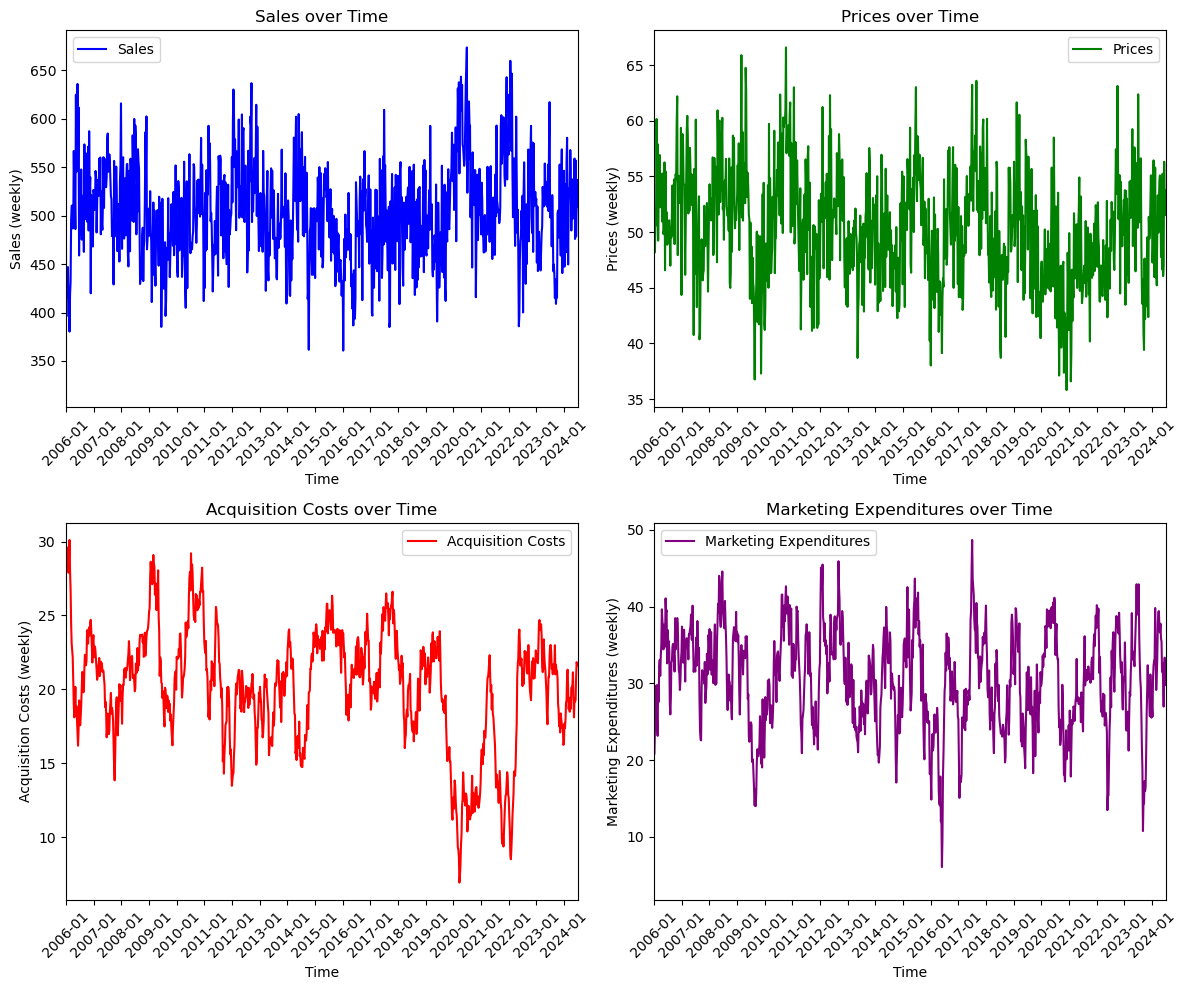

In [29]:
# give coloumns names
pricing_data.columns = ['dates', 's', 'p', 'c', 'm']
pricing_data['dates'] = pd.to_datetime(pricing_data['dates'], format='%d/%m/%Y')

plot_solara_pricing_data(pricing_data)

### Question VIII: simple regression of sales on prices

In [31]:
X = pricing_data['p']
y = pricing_data['s']  
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      s   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     28.59
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           1.11e-07
Time:                        19:13:47   Log-Likelihood:                -5448.4
No. Observations:                1018   AIC:                         1.090e+04
Df Residuals:                    1016   BIC:                         1.091e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        414.5996     16.282     25.464      0.000     382.650     446.549
p              1.7225      0.322      5.347      0.000       1.090       2.355
==============================================================================
Omnibus:                        6.574   Durbin-Watson:                   1.044
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.682
Skew:                           0.157   Prob(JB):                       0.0354
Kurtosis:                       3.243   Cond. No.                         514.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### computed analytically using ols

In [33]:
mean_p = pricing_data['p'].mean()
mean_s = pricing_data['s'].mean()

# Compute the numerator and denominator for beta (slope)
numerator = ((pricing_data['p'] - mean_p) * (pricing_data['s'] - mean_s)).sum()
denominator = ((pricing_data['p'] - mean_p) ** 2).sum()
beta = numerator / denominator
alpha = mean_s - beta * mean_p

alpha, beta

(414.59962295245487, 1.7225248928181076)

### Question XI: regression of prices on costs, use predicted price p to find structural-causal relation between sales and prices

### regression of prices on costs

In [36]:
# Regress prices on costs
x_costs = sm.add_constant(pricing_data['c'])  # costs independent
y_prices = pricing_data['p']  # prices dependent
p_on_c = sm.OLS(y_prices, x_costs)
results_p_on_c = p_on_c.fit()

print(results_p_on_c.summary())

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     253.3
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           4.36e-51
Time:                        19:13:47   Log-Likelihood:                -2964.1
No. Observations:                1018   AIC:                             5932.
Df Residuals:                    1016   BIC:                             5942.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.8635      0.732     53.119      0.0

### regression of sales on prices

In [38]:
# predictes price (p_hat)
pricing_data['p_hat'] = results_p_on_c.predict(x_costs)

# Regress sales on predicted prices (p_hat)
X_predicted_prices = sm.add_constant(pricing_data['p_hat'])  # p_hat independent
y_sales = pricing_data['s']  # sales dependent
s_on_p_hat= sm.OLS(y_sales, X_predicted_prices)
results_sales_on_predicted_prices = s_on_p_hat.fit()

print(results_sales_on_predicted_prices.summary())

                            OLS Regression Results                            
Dep. Variable:                      s   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     230.5
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           4.51e-47
Time:                        19:13:47   Log-Likelihood:                -5358.5
No. Observations:                1018   AIC:                         1.072e+04
Df Residuals:                    1016   BIC:                         1.073e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1005.3320     33.236     30.248      0.0

### Question XII: Hausman-durbin-wu test

### little chatgpt sanity check to see what the result has to be????? haha, its definitly endogenous, as expected

In [98]:
# # Step 1: Regress prices (p) on the instrument (costs c)
# X_instrument = sm.add_constant(pricing_data['c'])  # Instrument (costs)
# y_price = pricing_data['p']  # Endogenous variable (price)

# # OLS regression for the first step
# first_stage = sm.OLS(y_price, X_instrument).fit()

# # Get residuals from the first-stage regression
# pricing_data['residuals'] = first_stage.resid

# # Step 2: Regress sales (s) on prices (p) and the residuals from step 1
# X_second_stage = sm.add_constant(pricing_data[['p', 'residuals']])  # Prices and residuals
# y_sales = pricing_data['s']  # Dependent variable (sales)

# # OLS regression for the second step
# second_stage = sm.OLS(y_sales, X_second_stage).fit()

# # Output the results of the second-stage regression
# print(second_stage.summary())

#### Question 12

In [95]:
s = pricing_data['s']
p = pricing_data['p']
p_hat = pricing_data['p_hat']
T = len(pricing_data)

X_ols = sm.add_constant(p)
ols_model = sm.OLS(s, X_ols)
ols_results = ols_model.fit()


X_iv = sm.add_constant(p_hat)
iv_model = sm.OLS(s, X_iv)
iv_results = iv_model.fit()

beta_ols = ols_results.params['p']
beta_iv = iv_results.params['p_hat']
var_ols = ols_results.cov_params().loc['p', 'p']
var_iv = iv_results.cov_params().loc['p_hat', 'p_hat']

# Calculate the Hausman test statistic
hausman_stat = T * (beta_ols - beta_iv)**2 / (var_iv - var_ols)
p_value = 1 - stats.chi2.cdf(hausman_stat, df=1)

# Print results
print(f"Hausman Test Statistic: {hausman_stat}")
print(f"P-value: {p_value}")

# Decision rule
if p_value < 0.05:
    print("Rejecting the null hypothesis: Prices are endogenous")
else:
    print("Failed to reject the null hypothesis: Prices are exogenous")


Hausman Test Statistic: 422930.0141257326
P-value: 0.0
Rejecting the null hypothesis: Prices are endogenous


#### Question 13

In [84]:
s = pricing_data['s']        
p_hat = pricing_data['p_hat']  
m = pricing_data['m']      
X = sm.add_constant(np.column_stack((p_hat, m)))

model = sm.OLS(s, X)
results = model.fit()

alpha = results.params[0]
beta = results.params[1]   
psi = results.params[2]    

print(f"Alpha (Intercept): {alpha}")
print(f"Beta (Coefficient of p_hat): {beta}")
print(f"Psi (Coefficient of m): {psi}")


Alpha (Intercept): 879.1832476601971
Beta (Coefficient of p_hat): -10.263163316647123
Psi (Coefficient of m): 4.572896116311044


#### Question 14

In [50]:

# Define the target variables c and m
c = pricing_data['c']
m = pricing_data['m']

# Shift the variables by 1 period to create lagged variables
c_lag = c.shift(1)
m_lag = m.shift(1)

# Drop the first row due to NaN from the shift operation
pricing_data = pricing_data.dropna()

# Create a constant column for the intercept
c_lag = sm.add_constant(c_lag)
m_lag = sm.add_constant(m_lag)

# Fit autoregressive models for c_t and m_t

# Model for c_t
model_c = sm.OLS(c[1:], c_lag[1:])
results_c = model_c.fit()

# Model for m_t
model_m = sm.OLS(m[1:], m_lag[1:])
results_m = model_m.fit()

# Extract values for the parameters
mu_c = results_c.params[0]  # Intercept for c_t (mu_c)
phi_c = results_c.params[1]  # Coefficient of lagged c_t (phi_c)

mu_m = results_m.params[0]  # Intercept for m_t (mu_m)
phi_m = results_m.params[1]  # Coefficient of lagged m_t (phi_m)

# Print the results
print(f"mu_c (Intercept for c_t): {mu_c}")
print(f"phi_c (Coefficient of lagged c_t): {phi_c}")
print(f"mu_m (Intercept for m_t): {mu_m}")
print(f"phi_m (Coefficient of lagged m_t): {phi_m}")


mu_c (Intercept for c_t): 0.6818783648004136
phi_c (Coefficient of lagged c_t): 0.9663947061987499
mu_m (Intercept for m_t): 3.2398008172398973
phi_m (Coefficient of lagged m_t): 0.8927030380568697


In [51]:
# Get the last observed value for c_t and m_t from the data
c_last = pricing_data['c'].iloc[-1]  # Last value of c_t
m_last = pricing_data['m'].iloc[-1]  # Last value of m_t

# Predict c_{t+1} and m_{t+1}
c_t_plus_1 = mu_c + phi_c * c_last
m_t_plus_1 = mu_m + phi_m * m_last

# Print the predicted values
print(f"E[c_t+1|F_1]: {c_t_plus_1}")
print(f"E[m_t+1|F_1]: {m_t_plus_1}")


E[c_t+1|F_1]: 21.58427759667794
E[m_t+1|F_1]: 29.83206957267755


In [86]:
# Optimal Price
P_opt = (beta*c_t_plus_1 - alpha - psi*m_t_plus_1)/(2*beta) 

In [90]:
print(f"Optimal Price is {P_opt}")

Optimal Price is 60.2701686910954


In [100]:
pricing_data

,dates,s,p,c,m,p_hat,residuals
0,2005-01-01,500.000000,50.000000,20.021805,33.200625,50.167392,-0.167392
1,2005-01-08,449.303860,55.882011,18.674723,32.712796,49.406856,6.475155
2,2005-01-15,564.330379,48.051099,17.063911,32.103796,48.497423,-0.446325
3,2005-01-22,493.957460,49.484867,16.296832,29.963024,48.064345,1.420522
4,2005-01-29,541.364038,42.867625,17.041808,33.215894,48.484945,-5.617319
...,...,...,...,...,...,...,...
1013,2024-06-01,556.917728,47.036884,19.278435,26.977753,49.747700,-2.710816
1014,2024-06-08,478.349400,56.316331,20.820842,31.821882,50.618513,5.697818
1015,2024-06-15,510.213093,51.523393,21.845298,33.352506,51.196901,0.326492
1016,2024-06-22,536.814533,53.794799,21.643841,30.696786,51.083162,2.711637
